In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# Can close the connection since we're only doing one query
engine.dispose()

weather_df['temp_diff'] = weather_df['apparenttemperature'] - weather_df['temperature']
weather_df['humidity_windspeed_interaction'] = weather_df.humidity * weather_df.windspeed
# weather_df['humidity'] = stats.zscore(weather_df['humidity'])
# print(weather_df['humidity'])
print(weather_df.head())

                       date        summary preciptype  temperature  \
0 2006-03-31 22:00:00+00:00  Partly Cloudy       rain     9.472222   
1 2006-03-31 23:00:00+00:00  Partly Cloudy       rain     9.355556   
2 2006-04-01 00:00:00+00:00  Mostly Cloudy       rain     9.377778   
3 2006-04-01 01:00:00+00:00  Partly Cloudy       rain     8.288889   
4 2006-04-01 02:00:00+00:00  Mostly Cloudy       rain     8.755556   

   apparenttemperature  humidity  windspeed  windbearing  visibility  \
0             7.388889      0.89    14.1197        251.0     15.8263   
1             7.227778      0.86    14.2646        259.0     15.8263   
2             9.377778      0.89     3.9284        204.0     14.9569   
3             5.944444      0.83    14.1036        269.0     15.8263   
4             6.977778      0.83    11.0446        259.0     15.8263   

   loudcover  pressure                       dailysummary  temp_diff  \
0        0.0   1015.13  Partly cloudy throughout the day.  -2.083333   
1 

In [64]:
np.abs(weather_df.iloc[:,1:].corr().loc[:,'temperature']).sort_values(ascending=False)

temperature                       1.000000
apparenttemperature               0.992629
temp_diff                         0.635285
humidity                          0.632255
visibility                        0.392847
humidity_windspeed_interaction    0.251421
windbearing                       0.029988
windspeed                         0.008957
pressure                          0.005447
loudcover                              NaN
Name: temperature, dtype: float64

**Linear Regression Model**

In [68]:
# Y is the target variable
Y = weather_df['temp_diff']
# X is the feature set
X = weather_df[['humidity_windspeed_interaction']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              temp_diff   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                 4.426e+04
Date:                Thu, 19 Sep 2019   Prob (F-statistic):               0.00
Time:                        11:48:01   Log-Likelihood:            -1.6861e+05
No. Observations:               96453   AIC:                         3.372e+05
Df Residuals:                   96451   BIC:                         3.372e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.3511      0.008     43.171      0.000       0.335       0.367
humidity_windspeed_interaction    -0.1870      0.001   -210.380      0.000      -0.189      -0.185
==============================================================================
Omnibus:                     2785.669   Durbin-Watson:                   0.258
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4041.543
Skew:                          -0.307   Prob(JB):                         0.00
Kurtosis:                       3.793   Cond. No.                         16.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**KNN Model**

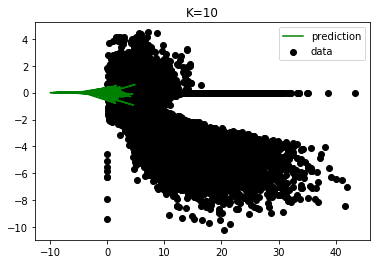

In [69]:
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)

X = pd.DataFrame(weather_df['humidity_windspeed_interaction'])
Y = weather_df['temp_diff']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

knn.fit(X_train, y_train)

# Set up our prediction line.

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(pd.DataFrame(y_test))

plt.scatter(X_train, y_train, c='k', label='data')
plt.plot(y_test, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10')
plt.show()

In [59]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Unweighted Accuracy: 0.36 (+/- 0.04)
